## Structure


## Setup

In [1]:
!pip install -r requirements.txt
# !pip install sentence-transformers
# !pip install mteb
# !pip install beir
# !pip install datasets
# !pip install wandb
# !pip install tqdm

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

## Matryoshka-Adaptor Implementation

### Architecture

In [2]:
import torch
import torch.nn.functional as F

# Define MatryoshkaAdaptor module - a simple MLP with skip connection which adapts the output of an embedding model
class MatryoshkaAdaptor(torch.nn.Module):
    """
    A PyTorch neural network module that adapts the output of an embedding model
    into a desired output dimension using two linear transformations with a ReLU activation in between.
    Includes a skip connection from input to output.
    """
    def __init__(self, input_output_dim, hidden_dim):
        """
        Initializes the MatryoshkaAdaptor module.
        
        Args:
            input_output_dim: An integer representing the input and output dimension of the module which are equal.
            hidden_dim: An integer representing the hidden dimension of the module.
            
        Returns:
            None
        """
        super(MatryoshkaAdaptor, self).__init__()
        self.input_output_dim = input_output_dim
        self.hidden_dim = hidden_dim
        
        # First linear layer to transform the input dimension to a hidden dimension
        self.linear1 = torch.nn.Linear(input_output_dim, hidden_dim)
        # Second linear layer to transform the hidden dimension to the output dimension which is same as input dimension
        self.linear2 = torch.nn.Linear(hidden_dim, input_output_dim)
        # Activation function to introduce non-linearity
        self.activation = torch.nn.ReLU()

    def forward(self, embedding):
        """
        Forward pass of the MatryoshkaAdaptor module.

        Args:
            embedding: A torch.Tensor of shape (batch_size, input_output_dim) representing the input embeddings.

        Returns:
            output: A torch.Tensor of shape (batch_size, input_output_dim) representing the matryoshka embeddings.
        """
        # Apply the first linear transformation followed by the activation function
        hidden_embedding = self.activation(self.linear1(embedding))
        
        # Apply the second linear transformation to get the final adapted embedding
        adapted_embedding = self.linear2(hidden_embedding)
        
        # Add the skip connection by adding the original embedding to the adapted embedding
        mat_embedding = adapted_embedding + embedding

        return mat_embedding

### Loss Functions

In [3]:
import torch
import torch.nn.functional as F

# Equation 1 in paper
def pairwise_similarity_loss(ori_corpus_embeddings, mat_corpus_embeddings, m_dims):
    """
    Computes the pairwise similarity loss between original embeddings and matryoshka embeddings.
    
    Args:
        ori_corpus_embeddings: A tensor of shape (batch_size, embedding_dim) representing the original embeddings.
        mat_corpus_embeddings: A tensor of shape (batch_size, embedding_dim) representing the matryoshka/adapted embeddings.
        m_dims: List of reduced matryoshka dimensionality values.
        
    Returns:
        loss: A scalar tensor representing the mean pairwise similarity loss.
    """

    # Original embeddings only need to be normalized and computed once: 

    # Normalize the embeddings along the embedding dimension to get the cosine similarity
    normalized_ori_corpus_embeddings = F.normalize(ori_corpus_embeddings, p=2, dim=1)
    # Compute the cosine similarity matrices
    original_similarity_matrix = torch.matmul(normalized_ori_corpus_embeddings, normalized_ori_corpus_embeddings.T)

    # Get the indices of the upper triangle of the matrices, excluding the diagonal
    batch_size = ori_corpus_embeddings.size(0)
    i, j = torch.triu_indices(batch_size, batch_size, offset=1)

    # Compute the pairwise cosine similarities
    original_pairwise_similarities = original_similarity_matrix[i, j]

    loss = 0.0
    for m in m_dims:
        # Reduce the matryoshka embeddings to m dimensions
        reduced_mat_corpus_embeddings = mat_corpus_embeddings[:, :m]

        # Normalize the embeddings along the embedding dimension to get the cosine similarity
        normalized_mat_corpus_embeddings = F.normalize(mat_corpus_embeddings, p=2, dim=1)
        
        # Compute the cosine similarity matrices
        matryoshka_similarity_matrix = torch.matmul(normalized_mat_corpus_embeddings, normalized_mat_corpus_embeddings.T)
        
        # Compute the pairwise cosine similarities
        matryoshka_pairwise_similarities = matryoshka_similarity_matrix[i, j]
        
        # Compute the absolute difference between corresponding pairwise similarities
        similarity_differences = torch.abs(original_pairwise_similarities - matryoshka_pairwise_similarities)
        
        # Sum up all the absolute differences to produce the final loss
        loss += torch.sum(similarity_differences)
    
    return loss

# Equation 2 in paper
def topk_similarity_loss(ori_corpus_embeddings, mat_corpus_embeddings, m_dims, k=10):
    """
    Computes the top-k similarity loss between original embeddings and matryoshka embeddings.
    
    Args:
        ori_corpus_embeddings: A tensor of shape (batch_size, embedding_dim) representing the original embeddings.
        mat_corpus_embeddings: A tensor of shape (batch_size, embedding_dim) representing the matryoshka/adapted embeddings.
        m_dims: List of reduced matryoshka dimensionality values.
        k: The number of top similarities to consider (default is 10).
        
    Returns:
        loss: A scalar tensor representing the top-k similarity loss.
    """
    
    # Normalize the original embeddings to get cosine similarity
    normalized_ori_corpus_embeddings = F.normalize(ori_corpus_embeddings, p=2, dim=1)
    
    # Compute the original cosine similarity matrix
    original_similarity_matrix = torch.matmul(normalized_ori_corpus_embeddings, normalized_ori_corpus_embeddings.T)
    
    # Exclude self-similarity by setting the diagonal to a very low value
    original_similarity_matrix.fill_diagonal_(-float('inf'))
    
    # For each embedding, get the top-k similarities for the original embeddings
    original_topk_values, _ = torch.topk(original_similarity_matrix, k, dim=1)
    
    loss = 0.0
    for m in m_dims:
        # Reduce the matryoshka embeddings to m dimensions
        reduced_mat_corpus_embeddings = mat_corpus_embeddings[:, :m]

        # Normalize the reduced matryoshka embeddings to get cosine similarity
        normalized_mat_corpus_embeddings = F.normalize(reduced_mat_corpus_embeddings, p=2, dim=1)
        
        # Compute the cosine similarity matrix for the reduced embeddings
        matryoshka_similarity_matrix = torch.matmul(normalized_mat_corpus_embeddings, normalized_mat_corpus_embeddings.T)
        
        # Exclude self-similarity by setting the diagonal to a very low value
        matryoshka_similarity_matrix.fill_diagonal_(-float('inf'))
        
        # For each embedding, get the top-k similarities for the matryoshka embeddings
        matryoshka_topk_values, _ = torch.topk(matryoshka_similarity_matrix, k, dim=1)
        
        # Compute the absolute difference between the top-k similarities
        similarity_differences = torch.abs(original_topk_values - matryoshka_topk_values)
        
        # Sum up all the absolute differences to accumulate the final loss
        loss += torch.sum(similarity_differences)
    
    return loss


# Equation 3 in paper
def reconstruction_loss(ori_corpus_embeddings, mat_corpus_embeddings):
    """
    Computes the reconstruction loss to ensure the matryoshka embeddings do not deviate
    significantly from the original embeddings, and thus act as a regularizer.
    
    Args:
        ori_corpus_embeddings: A tensor of shape (batch_size, embedding_dim) representing the original embeddings.
        mat_corpus_embeddings: A tensor of shape (batch_size, embedding_dim) representing the matryoshka/adapted embeddings.
        
    Returns:
        loss: A scalar tensor representing the reconstruction loss.
    """
    # Compute the absolute difference between embeddings
    abs_diff = torch.abs(ori_corpus_embeddings - mat_corpus_embeddings)
    
    # Sum over all dimensions
    loss = abs_diff.sum()

    return loss


# Equation 4 in paper
def unsupervised_objective_fn_loss(ori_corpus_embeddings, mat_corpus_embeddings, m_dims,
                                   k=10, alpha=1.0, beta=1.0):
    """
    Computes the overall unsupervised objective function loss as a combination of top-k similarity loss,
    alpha-scaled pairwise similarity loss, and beta-scaled reconstruction loss.
    
    Args:
        ori_corpus_embeddings: A tensor of shape (batch_size, embedding_dim) representing the original embeddings.
        mat_corpus_embeddings: A tensor of shape (batch_size, mat_embedding_dim) representing the matryoshka/adapted embeddings.
        m_dims: List of reduced matryoshka dimensionality values.
        k: The number of top similar embeddings to consider for the top-k similarity loss.
        alpha: A scaling factor for the pairwise similarity loss.
        beta: A scaling factor for the reconstruction loss.
        
    Returns:
        total_loss: A scalar tensor representing the combined unsupervised objective function loss.
    """
    # Compute the individual loss components
    topk_loss = topk_similarity_loss(ori_corpus_embeddings, mat_corpus_embeddings, m_dims, k)
    pairwise_loss = pairwise_similarity_loss(ori_corpus_embeddings, mat_corpus_embeddings, m_dims)
    rec_loss = reconstruction_loss(ori_corpus_embeddings, mat_corpus_embeddings)
    
    # Combine the losses with the given scaling factors
    total_loss = topk_loss + alpha * pairwise_loss + beta * rec_loss
    
    return total_loss


# Equation 5 in paper
def matryoshka_ranking_loss(query_embeddings, corpus_embeddings, relevance_scores, m_dims, k=10):
    """
    Computes the Matryoshka Ranking Loss using optimized matrix operations and normalization.
    
    Args:
        query_embeddings (torch.Tensor): Query embeddings of shape (num_queries, embedding_dim).
        corpus_embeddings (torch.Tensor): Corpus embeddings of shape (num_docs, embedding_dim).
        relevance_scores (torch.Tensor): Relevance scores of shape (num_queries, num_docs).
        m_dims (List[int]): List of reduced dimensionality values.
        k (int): Number of top similar documents to consider for the loss.
    
    Returns:
        torch.Tensor: The computed Matryoshka Ranking Loss.
    """
    
    total_loss = 0.0
    num_queries = query_embeddings.size(0)
    
    for m in m_dims:
        # Reduce embeddings to m dimensions
        reduced_query_embeddings = query_embeddings[:, :m]
        reduced_corpus_embeddings = corpus_embeddings[:, :m]
        
        # Normalize the embeddings to unit vectors
        reduced_query_embeddings = F.normalize(reduced_query_embeddings, p=2, dim=1)
        reduced_corpus_embeddings = F.normalize(reduced_corpus_embeddings, p=2, dim=1)
        
        # Compute cosine similarities
        similarities = torch.matmul(reduced_query_embeddings, reduced_corpus_embeddings.T)
        
        # Get the top k most similar documents for each query
        top_k_similarities, top_k_indices = torch.topk(similarities, k, dim=1, largest=True)
        
        # Gather the corresponding relevance scores
        top_k_relevance = torch.gather(relevance_scores, 1, top_k_indices)
        
        # Calculate pairwise differences for the top-k relevance scores and similarities
        relevance_diff = top_k_relevance.unsqueeze(2) - top_k_relevance.unsqueeze(1)
        sim_diff = top_k_similarities.unsqueeze(2) - top_k_similarities.unsqueeze(1)
        
        # Only consider pairs where the relevance score difference is positive
        positive_diff_mask = (relevance_diff > 0).float()
        
        # Compute the logistic loss with a numerically stable softplus
        log_loss = F.softplus(sim_diff)
        
        # Weight the loss by the relevance difference and accumulate
        weighted_loss = positive_diff_mask * relevance_diff * log_loss
        total_loss += weighted_loss.sum() / num_queries  # Normalize by the number of queries
    
    return total_loss



# Equation 6 in paper
def supervised_objective_fn_loss(ori_query_embeddings, ori_corpus_embeddings, mat_query_embeddings, mat_corpus_embeddings, relevance_scores, m_dims,
                                   k=5, alpha=1.0, beta=1.0, gamma=1.0):
    """
    Computes the overall supervised objective function loss as a combination of top-k similarity loss,
    alpha-scaled pairwise similarity loss, beta-scaled reconstruction loss and gamma-scaled matryoshka ranking loss.
    
    Args:
        ori_corpus_embeddings: A tensor of shape (batch_size, embedding_dim) representing the original embeddings.
        mat_corpus_embeddings: A tensor of shape (batch_size, mat_embedding_dim) representing the matryoshka embeddings.
        relevance_scores: A tensor of shape (batch_size, num_docs) representing the relevance scores.
        m_dims: List of reduced matryoshka dimensionality values.
        k: The number of top similar embeddings to consider for the top-k similarity loss.
        alpha: A scaling factor for the pairwise similarity loss.
        beta: A scaling factor for the reconstruction loss.
        
    Returns:
        total_loss: A scalar tensor representing the combined unsupervised objective function loss.
    """
    # Compute the individual loss components
    topk_loss = topk_similarity_loss(ori_corpus_embeddings, mat_corpus_embeddings, m_dims, k)
    pairwise_loss = pairwise_similarity_loss(ori_corpus_embeddings, mat_corpus_embeddings, m_dims)
    rec_loss = reconstruction_loss(ori_corpus_embeddings, mat_corpus_embeddings, beta)
    ranking_loss = matryoshka_ranking_loss(ori_corpus_embeddings, mat_corpus_embeddings, relevance_scores, m_dims)

    # Combine the losses with the given scaling factors
    total_loss = topk_loss + alpha * pairwise_loss + beta * rec_loss + gamma * ranking_loss
    
    return total_loss

### Train Function

This train function is designed for both unsupervised and supervised methods to train the Matryoshka Adaptor (not the embedding model).

In [4]:
import torch
from torch.optim import Adam
import wandb
from tqdm import tqdm

def train(model, mat_adaptor, train_loader, loss_fn, config, run_name):
    """
    Trains the MatryoshkaAdaptor module using the provided training data.

    Args:
        model: A SentenceTransformer model to generate embeddings.
        mat_adaptor: A MatryoshkaAdaptor module to adapt the embeddings.
        train_loader: A DataLoader object for the training dataset.
        loss_fn: A loss function to compute the loss between original and matryoshka embeddings.
        config: A dictionary containing hyperparameters for training.
        run_name: A string representing the name of the save path run.
    Returns:
        None
    """

    # Detect if CUDA is available and set the device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move the model and mat_adaptor to the device
    model.to(device)
    mat_adaptor.to(device)

    # Unpack the hyperparameters
    epochs = config.get('epochs', 5)
    lr = config.get('lr', 1e-3)
    k = config.get('k', 10)  # Top-k similarity loss
    m_dims = config.get('m_dims', [64, 128, 256])  # Matryoshka embedding dimensions
    alpha = config.get('alpha', 1.0)  # Pairwise similarity loss scaling factor (alpha in paper)
    beta = config.get('beta', 1.0)  # Reconstruction loss scaling factor (beta in paper)
    gamma = config.get('gamma', 1.0)  # Ranking loss scaling factor (gamma in paper)

    # Initialize Weights & Biases
    if config.get('wandb', False):
        wandb.init(project="matryoshka-training", config=config)
        config = wandb.config

    # Define an optimizer for the MatryoshkaAdaptor parameters
    optimizer = Adam(mat_adaptor.parameters(), lr=lr)

    # Set embedding model to eval mode (so that gradients only apply to the MatryoshkaAdaptor)
    model.eval()
    
    # Set MatryoshkaAdaptor to training mode
    mat_adaptor.train()

    for epoch in tqdm(range(epochs), desc="Epochs"):
        total_loss = 0

        # Loop over batches in the current epoch
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            if isinstance(batch, list):
                ori_embeddings = model.encode(batch, convert_to_tensor=True).to(device)  # model batched embeddings
                mat_embeddings = mat_adaptor(ori_embeddings)
                loss = loss_fn(ori_embeddings, mat_embeddings, m_dims, k=k, alpha=alpha, beta=beta)

            elif isinstance(batch, dict):
                queries, corpus, relevance_scores = batch['query'], batch['corpus'], batch['relevance'].to(device)
                ori_query_embeddings = model.encode([queries, corpus], convert_to_tensor=True).to(device)
                ori_corpus_embeddings = model.encode(corpus, convert_to_tensor=True).to(device)
                mat_query_embeddings = mat_adaptor(ori_query_embeddings).to(device)
                mat_corpus_embeddings = mat_adaptor(ori_corpus_embeddings).to(device)
                loss = loss_fn(ori_query_embeddings, ori_corpus_embeddings, mat_query_embeddings, mat_corpus_embeddings, relevance_scores, m_dims, k=k, alpha=alpha, beta=beta, gamma=gamma)

            else:
                raise ValueError("Invalid batch format. Please provide a list or dictionary.")

            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Compute gradients
            optimizer.step()       # Update weights

            print(F"Loss: {loss.item():.4f}")
            total_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        
        # Log the average loss to W&B
        if config.get('wandb', False):
            wandb.log({"epoch": epoch + 1, "loss": avg_loss})
        
        # Print average loss for the epoch
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        # Save model checkpoint every 5 epochs and on the final epoch
        if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
            checkpoint_path = f"{run_name}_epoch_{epoch+1}.pt"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': mat_adaptor.state_dict(),
                'input_output_dim': mat_adaptor.input_output_dim,
                'hidden_dim': mat_adaptor.hidden_dim,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")

    # Final save (this is optional if the final epoch is a multiple of 5)
    final_checkpoint_path = f"{run_name}_epoch_{epochs}_final.pt"
    torch.save({
        'epoch': epochs,
        'model_state_dict': mat_adaptor.state_dict(),
        'input_output_dim': mat_adaptor.input_output_dim,
        'hidden_dim': mat_adaptor.hidden_dim,
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, final_checkpoint_path)
    print(f"Final checkpoint saved at {final_checkpoint_path}")
    

    # Finish the W&B run
    if config.get('wandb', False):
        wandb.finish()


## Training of Adaptor

### Unsupervised Implementation

#### Prepare Datasets 

We will use BEIR's NFCorpus, and train on the corpus only in an unsupervised manner, as detailed in the paper.

In [5]:
from datasets import load_dataset
from torch.utils.data import DataLoader, random_split
import torch

# Load the dataset
# ds = load_dataset("BeIR/nfcorpus", "corpus")
ds = load_dataset("BeIR/webis-touche2020", "corpus")

# Access the 'corpus' dataset
dataset = ds['corpus']['text']

# Define the split sizes
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#### Prepare Embedding Model and Matryoshka-Adaptor

In [6]:
from sentence_transformers import SentenceTransformer

# Embedding Model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Matryoshka-Adaptor
input_output_dim = model.get_sentence_embedding_dimension() # Embedding dimension for model (d in paper)
hidden_dim = input_output_dim # Let hidden layer dimension equal the embedding model dimension
mat_adaptor = MatryoshkaAdaptor(input_output_dim, hidden_dim)

#### Train Matryoshka-Adaptor

In [7]:
hyperparams = {
    'epochs': 5,
    'lr': 1e-3,
    'batch_size': 128,
    'k': 5,  # Top-k similarity loss
    'm_dims': [i for i in range(1, 385)],  # Matryoshka embedding dimensions up to the original embedding dimension
    'alpha': 1.0,  # Pairwise similarity loss scaling factor (alpha in paper)
    'beta': 1.0,  # reconstruction loss scaling factor (beta in paper)
    'wandb': False
}

# Create DataLoader for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)

run_name = "ckpts/unsupervised_ma"
train(model, mat_adaptor, train_dataloader, unsupervised_objective_fn_loss, hyperparams, run_name)

Epochs:   0%|          | 0/5 [01:54<?, ?it/s]


KeyboardInterrupt: 

### Supervised Implementation

#### Prepare Datasets

As before, we will use BEIR's NFCorpus, and train on the corpus-query pairs in a supervised manner, as detailed in the paper.
We need to manually download the BEIR dataset since the qrels cannot be accessed on the huggingface dataset. 

In [ ]:
from beir import util, LoggingHandler
from beir.datasets.data_loader import GenericDataLoader
import torch
from torch.utils.data import Dataset, DataLoader
import logging

# Set up logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO, handlers=[LoggingHandler()])

# Define the dataset name and the path to store it
dataset = "nfcorpus"
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip"
data_path = util.download_and_unzip(url, "datasets")

# Load train and test data
train_corpus, train_queries, train_qrels = GenericDataLoader(data_path).load(split="train")
dev_corpus, dev_queries, dev_qrels = GenericDataLoader(data_path).load(split="dev")
test_corpus, test_queries, test_qrels = GenericDataLoader(data_path).load(split="test")

class BEIRDataset(Dataset):
    def __init__(self, query, corpus, qrels):
        self.query = query
        self.corpus = corpus
        self.qrels = qrels
        self.query_ids = list(query.keys())
        
    def __len__(self):
        return len(self.query_ids)
    
    def __getitem__(self, idx):
        query_id = self.query_ids[idx]
        query = self.query[query_id]
        
        relevant_docs = self.qrels.get(query_id, {})
        
        # Get all document ids and relevance for this query
        corpus_ids = list(relevant_docs.keys())
        relevance = [relevant_docs[doc_id] for doc_id in corpus_ids]
        
        # Get document texts
        corpus = [self.corpus[doc_id] for doc_id in corpus_ids]
        
        return {
            'query_id': query_id,
            'query': query,
            'corpus_ids': corpus_ids,
            'corpus': corpus,
            'relevance': relevance
        }
    

def collate_fn(batch):
    query_ids = [item['query_id'] for item in batch]
    query = [item['query'] for item in batch]
    corpus_ids = [item['corpus_ids'] for item in batch]
    corpus = [item['corpus'] for item in batch]
    relevance = [item['relevance'] for item in batch]
    
    # Pad sequences if necessary
    max_docs = max(len(docs) for docs in corpus_ids)
    
    padded_corpus_ids = [docs + [''] * (max_docs - len(docs)) for docs in corpus_ids]
    padded_corpus = [texts + [''] * (max_docs - len(texts)) for texts in corpus]
    padded_relevance = [s + [0] * (max_docs - len(s)) for s in relevance]
    
    return {
        'query_ids': query_ids,
        'query': query,
        'corpus_ids': padded_corpus_ids,  # Keep as a list of lists
        'corpus': padded_corpus,  # Keep as a list of lists
        'relevance': torch.tensor(padded_relevance)  # Convert only relevance to tensor
    }


#### Prepare Embedding Model and Matryoshka-Adaptor

In [ ]:
from sentence_transformers import SentenceTransformer

# Embedding Model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Matryoshka-Adaptor
input_output_dim = model.get_sentence_embedding_dimension() # Embedding dimension for model (d in paper)
hidden_dim = input_output_dim # Let hidden layer dimension equal the embedding model dimension
mat_adaptor = MatryoshkaAdaptor(input_output_dim, hidden_dim)

#### Train Matryoshka-Adaptor

In [ ]:
hyperparams = {
    'epochs': 5,
    'lr': 5e-4,
    'batch_size': 128,
    'k': 5,  # Top-k similarity loss
    'm_dims': [i for i in range(1, 385)],  # Matryoshka embedding dimensions up to the original embedding dimension
    'alpha': 1.0,  # Pairwise similarity loss scaling factor (alpha in paper)
    'beta': 1.0,  # reconstruction loss scaling factor (beta in paper)
    'gamma': 1.0,  # Ranking loss scaling factor (gamma in paper)
    'wandb': False,
}

train_dataset = BEIRDataset(train_queries, train_corpus, train_qrels)
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True, collate_fn=collate_fn)
    
# dev_dataset = BEIRDataset(dev_queries, dev_corpus, dev_qrels)
# dev_dataloader = DataLoader(dev_dataset, batch_size=hyperparams['batch_size'], shuffle=True, collate_fn=collate_fn)

# test_dataset = BEIRDataset(test_queries, test_corpus, test_qrels)
# test_dataloader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'], shuffle=True, collate_fn=collate_fn)

run_name = "ckpts/supervised_ma"
train(model, mat_adaptor, train_dataloader, supervised_objective_fn_loss, hyperparams, run_name)

## BEIR Evaluation using NFCorpus

### Unmodified Model Performance for all-MiniLM-L6-v2

In [ ]:
import torch
from sentence_transformers import SentenceTransformer

# Rudimentary SentenceTransformer subclass to crop embeddings
class CropSentenceTransformer(SentenceTransformer):
    def __init__(self, model_name_or_path, m):
        super(CropSentenceTransformer, self).__init__(model_name_or_path)
        self.model = SentenceTransformer(model_name_or_path)
        self.m = m

    def encode(self, sentences, **kwargs):
        # Get the embeddings from the embedding model
        embeddings = self.model.encode(sentences, **kwargs)

        # Crop the embeddings to the desired dimension m
        reduced_embeddings = embeddings[:, :self.m]
        
        return reduced_embeddings

In [ ]:
import mteb
m_dims = [64, 128, 256, 384]
for m in m_dims:
    model = CropSentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', m)
    model_name = 'all-MiniLM-L6-v2_BASE'

    # Define the BEIR tasks you want to evaluate on
    tasks = mteb.get_tasks(tasks=["NFCorpus"])

    # Evaluate the model on the benchmark
    evaluation = mteb.MTEB(tasks=tasks)
    results = evaluation.run(model, output_folder=f"results/NFCorpus/{model_name}/{m}", eval_splits=["test"])

### all-MiniLM-L6-v2 + PCA

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import numpy as np

class PCASentenceTransformer(SentenceTransformer):
    """
    A SentenceTransformer model that applies PCA to reduce the dimensionality of the embeddings. 
    It serves as a wrapper to the inputted SentenceTransformer. 
    """
    def __init__(self, model_name_or_path, pca_components=128):
        super().__init__(model_name_or_path)
        self.pca_components = pca_components
        self.pca = None

    def fit_pca(self, embeddings):
        """Fits PCA on the provided embeddings."""
        self.pca = PCA(n_components=self.pca_components)
        self.pca.fit(embeddings)

    def encode(self, sentences, **kwargs):
        """Encodes the sentences and applies PCA to reduce dimensions."""
        # First, get the embeddings from the parent class method
        embeddings = super().encode(sentences, **kwargs)

        # If PCA is not fitted, fit it using the embeddings
        if self.pca is None:
            self.fit_pca(embeddings)

        # Transform the embeddings using the fitted PCA model
        reduced_embeddings = self.pca.transform(embeddings)
        return reduced_embeddings

In [ ]:
import mteb

m_dims = [64, 128, 256, 384]
for m in m_dims:
    # Create PCA model
    pca_model = PCASentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', pca_components=m)
    model_name = f'all-MiniLM-L6-v2_PCA'

    # Ensure the model is on the right device
    pca_model.to('cpu') # sklearn PCA does not support GPU

    # Define the BEIR tasks you want to evaluate on
    tasks = mteb.get_tasks(tasks=["NFCorpus"])

    # Evaluate the model on the benchmark
    evaluation = mteb.MTEB(tasks=tasks)
    
    # Ensure the model's output is on the CPU before passing to numpy
    results = evaluation.run(pca_model, output_folder=f"results/NFCorpus/{model_name}/{m}", eval_splits=["test"])


### all-MiniLM-L6-v2 + Unsupervised Matryoshka Adaptor

In [1]:
import torch
from sentence_transformers import SentenceTransformer

class MASentenceTransformer(SentenceTransformer):
    def __init__(self, model_name_or_path, ma_ckpt, m):
        super(MASentenceTransformer, self).__init__(model_name_or_path)
        self.model = SentenceTransformer(model_name_or_path)
        self.m = m

        # Matryoshka-Adaptor
        self.mat_adaptor = MatryoshkaAdaptor(self.model.get_sentence_embedding_dimension(), self.model.get_sentence_embedding_dimension())

        # Load the state dictionary from the checkpoint
        self.mat_adaptor.load_state_dict(torch.load(ma_ckpt)['model_state_dict'])

    def encode(self, sentences, **kwargs):
        # Get the embeddings from the embedding model
        embeddings = self.model.encode(sentences, **kwargs)

        # Transform the embeddings using the Matryoshka Adaptor
        reduced_embeddings = self.mat_adaptor(embeddings)

        # Crop the embeddings to the desired dimension m
        reduced_embeddings = reduced_embeddings[:, :self.m]
        
        return reduced_embeddings

In [7]:
import mteb

ma_ckpt = "ckpts/multi/text-only_epoch_1.pt"
m_dims = [64, 128, 256, 384]
for m in m_dims:
    ma_model = MASentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', ma_ckpt=ma_ckpt, m=m)
    ma_model.to('cuda')
    model_name = f'all-MiniLM-L6-v2_MAT_ADAPTOR_UNSUPERVISED_Multi'

    # Define the BEIR tasks you want to evaluate on
    tasks = mteb.get_tasks(tasks=["NFCorpus"])

    # Evaluate the model on the benchmark
    evaluation = mteb.MTEB(tasks=tasks)
    results = evaluation.run(ma_model, output_folder=f"results/NFCorpus/{model_name}/{m}", eval_splits=["test"])
    print(results)


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

Batches: 100%|██████████| 29/29 [04:53<00:00, 10.13s/it]


[MTEBResults(task_name=NFCorpus, scores=...)]


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

Batches: 100%|██████████| 29/29 [04:21<00:00,  9.03s/it]


[MTEBResults(task_name=NFCorpus, scores=...)]


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

Batches: 100%|██████████| 29/29 [04:18<00:00,  8.90s/it]


[MTEBResults(task_name=NFCorpus, scores=...)]


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

Batches: 100%|██████████| 29/29 [03:45<00:00,  7.76s/it]


[MTEBResults(task_name=NFCorpus, scores=...)]


### Visualize Results

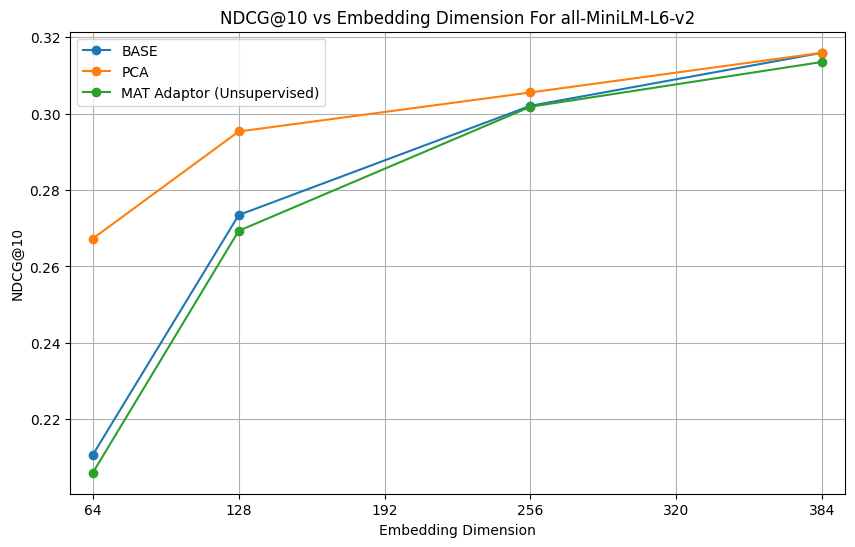

In [9]:
import json 
import matplotlib.pyplot as plt

# BASE results
base_result_paths = {
    "64": "results/NFCorpus/all-MiniLM-L6-v2_BASE/64/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
    "128": "results/NFCorpus/all-MiniLM-L6-v2_BASE/128/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
    "256": "results/NFCorpus/all-MiniLM-L6-v2_BASE/256/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
    "384": "results/NFCorpus/all-MiniLM-L6-v2_BASE/384/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json"
}

# PCA results
pca_result_paths = {
    "64": "results/NFCorpus/all-MiniLM-L6-v2_PCA/64/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
    "128": "results/NFCorpus/all-MiniLM-L6-v2_PCA/128/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
    "256": "results/NFCorpus/all-MiniLM-L6-v2_PCA/256/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
    "384": "results/NFCorpus/all-MiniLM-L6-v2_BASE/384/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
}

# Unsupervised Matryoshka-Adaptor results
# unsup_mat_adaptor_result_paths = {
#     "64": "results/NFCorpus/all-MiniLM-L6-v2_MAT_ADAPTOR_UNSUPERVISED/64/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
#     "128": "results/NFCorpus/all-MiniLM-L6-v2_MAT_ADAPTOR_UNSUPERVISED/128/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
#     "256": "results/NFCorpus/all-MiniLM-L6-v2_MAT_ADAPTOR_UNSUPERVISED/256/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
#     # "384": "results/NFCorpus/all-MiniLM-L6-v2_MAT_ADAPTOR_UNSUPERVISED/384/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json"
# }

# Multi

unsup_mat_adaptor_result_paths = {
    "64": "results/NFCorpus/all-MiniLM-L6-v2_MAT_ADAPTOR_UNSUPERVISED_Multi/64/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
    "128": "results/NFCorpus/all-MiniLM-L6-v2_MAT_ADAPTOR_UNSUPERVISED_Multi/128/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
    "256": "results/NFCorpus/all-MiniLM-L6-v2_MAT_ADAPTOR_UNSUPERVISED_Multi/256/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
    "384": "results/NFCorpus/all-MiniLM-L6-v2_MAT_ADAPTOR_UNSUPERVISED_Multi/384/sentence-transformers__all-MiniLM-L6-v2/8b3219a92973c328a8e22fadcfa821b5dc75636a/NFCorpus.json",
}

def load_results(result_paths):
    dimensions = []
    ndcg_at_10_values = []
    
    for dim, path in result_paths.items():
        with open(path, 'r') as f:
            data = json.load(f)
            # Extract the NDCG@10 score
            ndcg_at_10 = data['scores']['test'][0]['ndcg_at_10']
            dimensions.append(int(dim))
            ndcg_at_10_values.append(ndcg_at_10)
    
    return dimensions, ndcg_at_10_values

# Load the results for each method
base_dimensions, base_ndcg_at_10_values = load_results(base_result_paths)
pca_dimensions, pca_ndcg_at_10_values = load_results(pca_result_paths)
unsup_mat_adaptor_dimensions, unsup_mat_adaptor_ndcg_at_10_values = load_results(unsup_mat_adaptor_result_paths)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot BASE
plt.plot(base_dimensions, base_ndcg_at_10_values, marker='o', label='BASE')

# Plot PCA
plt.plot(pca_dimensions, pca_ndcg_at_10_values, marker='o', label='PCA')

# Plot Unsupervised Matryoshka-Adaptor
plt.plot(unsup_mat_adaptor_dimensions, unsup_mat_adaptor_ndcg_at_10_values, marker='o', label='MAT Adaptor (Unsupervised)')

# Adding labels and title
plt.xticks(range(0, max(base_dimensions) + 64, 64))
plt.xlim(min(base_dimensions)-10, max(base_dimensions) + 10)
plt.title('NDCG@10 vs Embedding Dimension For all-MiniLM-L6-v2')
plt.xlabel('Embedding Dimension')
plt.ylabel('NDCG@10')
plt.grid(True)
plt.legend()
plt.show()
